In [1]:
# In this notebook, you learn:
#
# 1) How to create a simple rule based model that generates new names?
#
# Resources:
# 1) https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10
#       -- The original resource that explains how to create a simple rule based model that generates new names.

In [2]:
# The idea here is that we look at the names in the dataset, learn the patterns and then generate new 
# namesbased on the patterns we have learned.
#
# For now, we will follow the simplest rule that helps us generate new names:
# 1) For every character, we will generate a new character and append it to the running name.
# 2) We will repeat the above step until an 'end character' is generated.
#
# For example, if the name generated at the end is "virat", the process looks something like this:
# we will start with the special 'start_character'.
# [] --> [start_character]
# Then we will generate a new character 'v' and append it to the running name.
# [start_character] --> ['start_character', v]
# Then we will generate a new character 'i' and append it to the running name.
# ['start_character', v] --> ['start_character', v, i]
# Then we will generate a new character 'r' and append it to the running name.
# ['start_character', v, i] --> ['start_character', v, i, r]
# Then we will generate a new character 'a' and append it to the running name.
# ['start_character', v, i, r] --> ['start_character', v, i, r, a]
# Then we will generate a new character 't' and append it to the running name.
# ['start_character', v, i, r, a] --> ['start_character', v, i, r, a, t]
# Finally, we will generate the 'end_character' and append it to the running name.
# ['start_character', v, i, r, a, t] --> ['start_character', v, i, r, a, t, 'end_character']
#
# As for the character predictions, we will use the following rule:
#
# We will learn the probability of a character appearing after another character in the dataset i.e., 
# we will compute P(character | previous_character) for all characters in the dataset.
# 
# For example:
# P(a | j) = Probability of 'a' appearing after 'j'.
# P(b | j) = Probability of 'b' appearing after 'j'.
# 
# Of course, the sum of all these probabilities for any single character should be 1 i.e.,
# P(a|j) + P(b|j) + ... + P(z|j) + P('end character'|j) = 1
#
# This essentially gives us 27 probability distributions (26 alphabets + 'end character'), one for each 
# character. 
#
# Let's say the current character is 'f' and now we want to predict the next character. We will look at 
# the probability distribution corresponding to character 'f' i.e., the probability of each character 
# (a, b, c, ..., y, z, 'end character') appearing after 'f' in the dataset.  We will then sample a 
# character from this distribution to get the next character. We do this until we sample the 
# 'end_character'.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
import torch

In [4]:
DATASET_FILEPATH = "../Data/names.txt"

In [5]:
# Read the names from the dataset and create a list of names.
with open(DATASET_FILEPATH, "r") as f:
    names = [name.strip() for name in f.readlines()]

In [6]:
names[:10]

['albonsha',
 'beenapreethi',
 'thushniha',
 'aakaksha',
 'dumeethran',
 'luhit',
 'valam',
 'harinyai',
 'sakthikaa',
 'kaveetha']

In [7]:
# Let's make a special character to represent the start and the end of the name.
# Normally, we would use separate character for start and end. However, as explained in Karpathy's video,
# we don't need to do that for this case. We can use the same character for both start and end.
bound_character = '.'

In [8]:
# Let's say we have a name "virat". We need a way to represent that 'v' is the first character and 't' is the 
# last character. To be able to do that, we will add a bound_character at the start and end of the name.
# So, the name "virat" will be represented as ".virat."
sample_name = "virat"
modifiled_sample_name = bound_character + sample_name + bound_character
print(f"modifiled_sample_name: {modifiled_sample_name}")
print("-" * 75)

# We need to count the number of times each character-pair appears in the name.
# We can do this by using the zip function to iterate over consecutive character-pairs in the name.
for first_character, second_character in zip(modifiled_sample_name, modifiled_sample_name[1:]):
    print(f"first_character: {first_character}, second_character: {second_character}")

modifiled_sample_name: .virat.
---------------------------------------------------------------------------
first_character: ., second_character: v
first_character: v, second_character: i
first_character: i, second_character: r
first_character: r, second_character: a
first_character: a, second_character: t
first_character: t, second_character: .


In [9]:
# It would be easier if we maintain an integer mapping for each character. So, let's create a mapping.
char_to_int = {char: idx + 1 for idx, char in enumerate(string.ascii_lowercase)}
# Let's add the bound_character to the mapping.
char_to_int[bound_character] = 0
print(char_to_int)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [10]:
# Let's also create the reverse mapping. This will be useful when we try to plot the counts in the heatmap.
int_to_char = {idx: char for char, idx in char_to_int.items()}
print(int_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# Let's create a tensor to store the counts of each caracter-pair.
# Each 1D tensor will represent the counts of every character appearing after a particular character.
# For example, the 1D tensor at index 1 will represent the counts of every character appearing after 'a'.
# The 1D tensor at index 2 will represent the counts of every character appearing after 'b' and so on.
# In general, 
# char_counts[i][j] = Number of times character j appears after character i 
#                                 or 
#                     Number of times pair (ij) appears in the dataset.
char_counts = torch.zeros(size=(27, 27), dtype=torch.int32)

In [12]:
# We want to count the number of times a character pair appears in the dataset. Let's do that.
for name in names:
    name = bound_character + name + bound_character
    for first_character, second_character in zip(name, name[1:]):
        first_character_idx = char_to_int[first_character]
        second_character_idx = char_to_int[second_character]
        char_counts[first_character_idx][second_character_idx] += 1

In [13]:
def plot_heatmap(input: torch.Tensor, int_to_char: torch.Tensor, title: str=""):
    """Plots a heatmap of the character-pair counts.

    Args:
        input (torch.Tensor): Tensor of shape (27, 27)
        int_to_char (torch.Tensor): Mapping from integer to character.
        title (str, optional): Title of the heatmap. Defaults to "".
    """
    # Convert the tensor to a NumPy array
    input_array = input.numpy()
    # Create the heatmap using seaborn with a lighter colormap.
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(input_array, cmap="YlGnBu", cbar=False)  # Use a lighter colormap like "YlGnBu"\
    # Add the character-pair and the count of that pair to every cell in the heatmap.
    for i in range(0, 27):
        for j in range(0, 27):
            if isinstance(input[i][j].item(), int):
                value_text = input[i][j]
            else:
                value_text = f"{input[i][j]:.3f}"
            # Create the character-pair and the count of that pair as a string to be displayed in the cell.
            cell_text = f"{int_to_char[i]}{int_to_char[j]}\n{value_text}"
            # Add the created text to the corresponding cell in the heatmap.
            cell_text_obj = ax.text(x=j + 0.5, y=i + 0.5, s=cell_text, ha="center", va="center", color="black")
    # Adjust cell size (increase the font size)
    # sns.set(font_scale=1)  # Adjust the font scale as needed
    # Remove x and y ticks. We already have the character-pair labels in the heatmap.
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    # Add title to the heatmap.
    plt.title(title)
    plt.show()

In [14]:
type(char_counts[3][4].item())

int

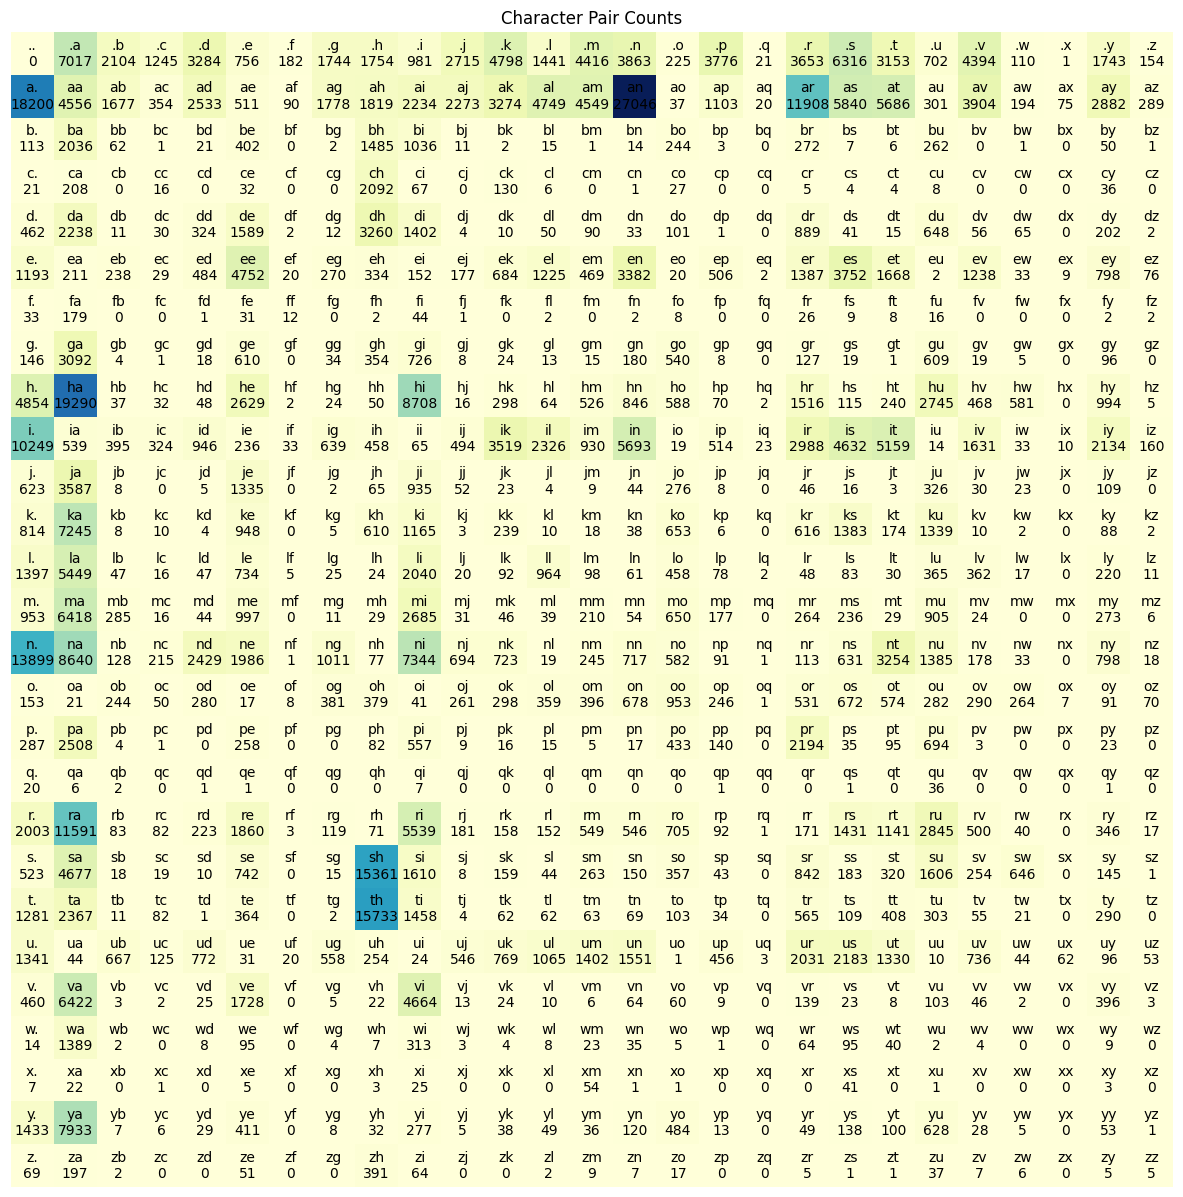

In [15]:
# Let's visualize the character-pair counts using a heatmap.
plot_heatmap(char_counts, int_to_char, title="Character Pair Counts")

In [16]:
# In the above heatmap, we can see that some of the pairs don't occur at all and contain 0 counts. This can issues when
# we calculate the probabilities using these counts. To avoid this, let's add '1' to every count in the tensor.
char_counts += 1

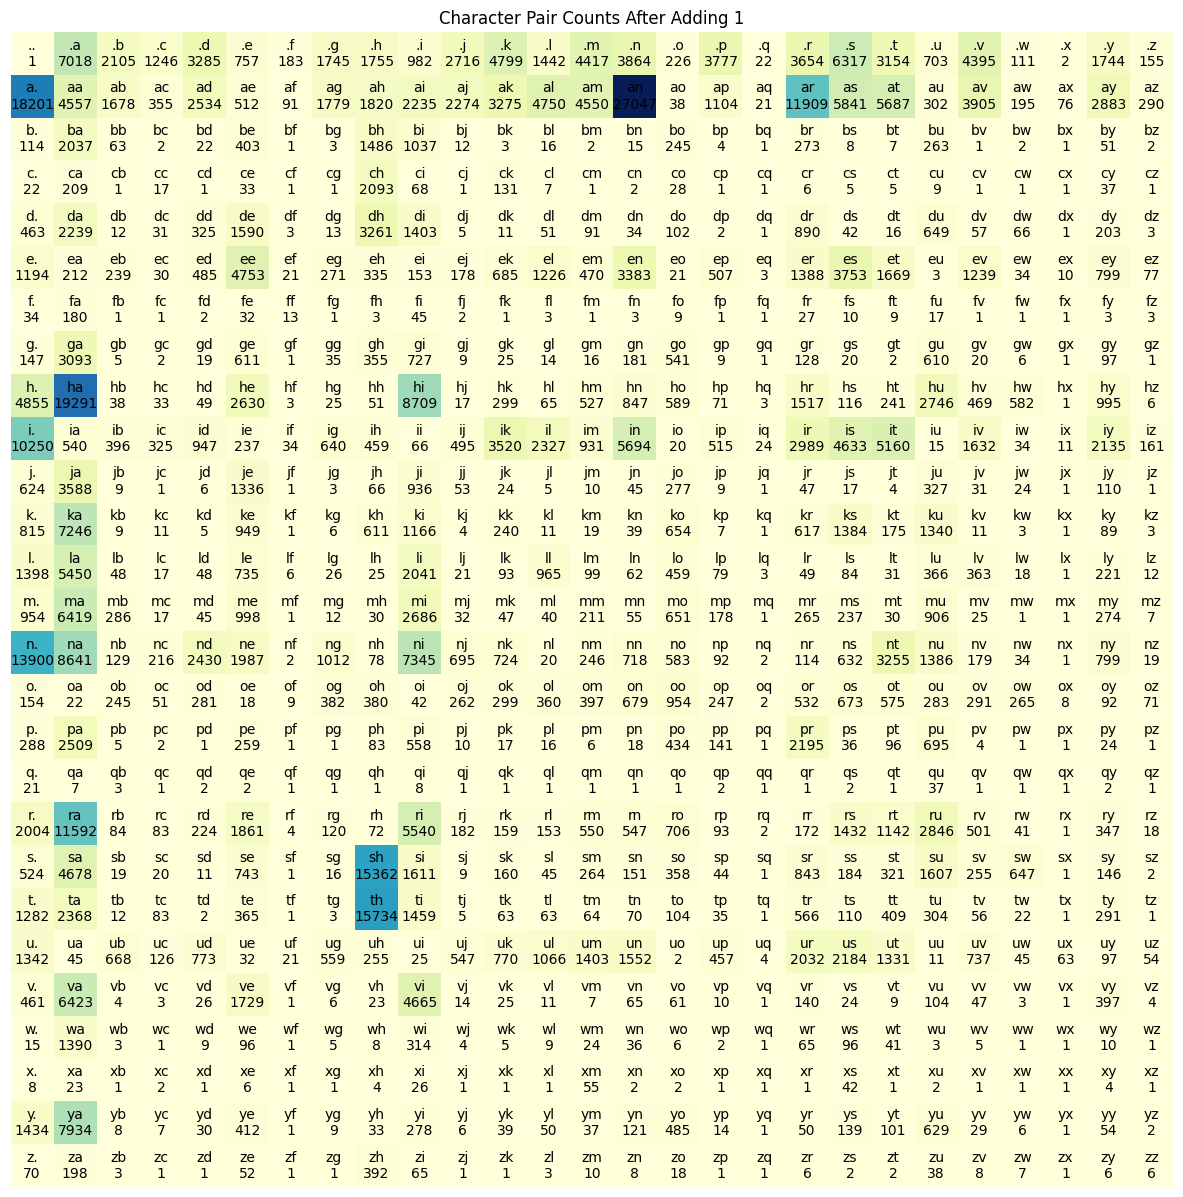

In [17]:
# Let's visualize the character-pair counts after adding '1' to every count using a heatmap.
plot_heatmap(char_counts, int_to_char, title="Character Pair Counts After Adding 1")

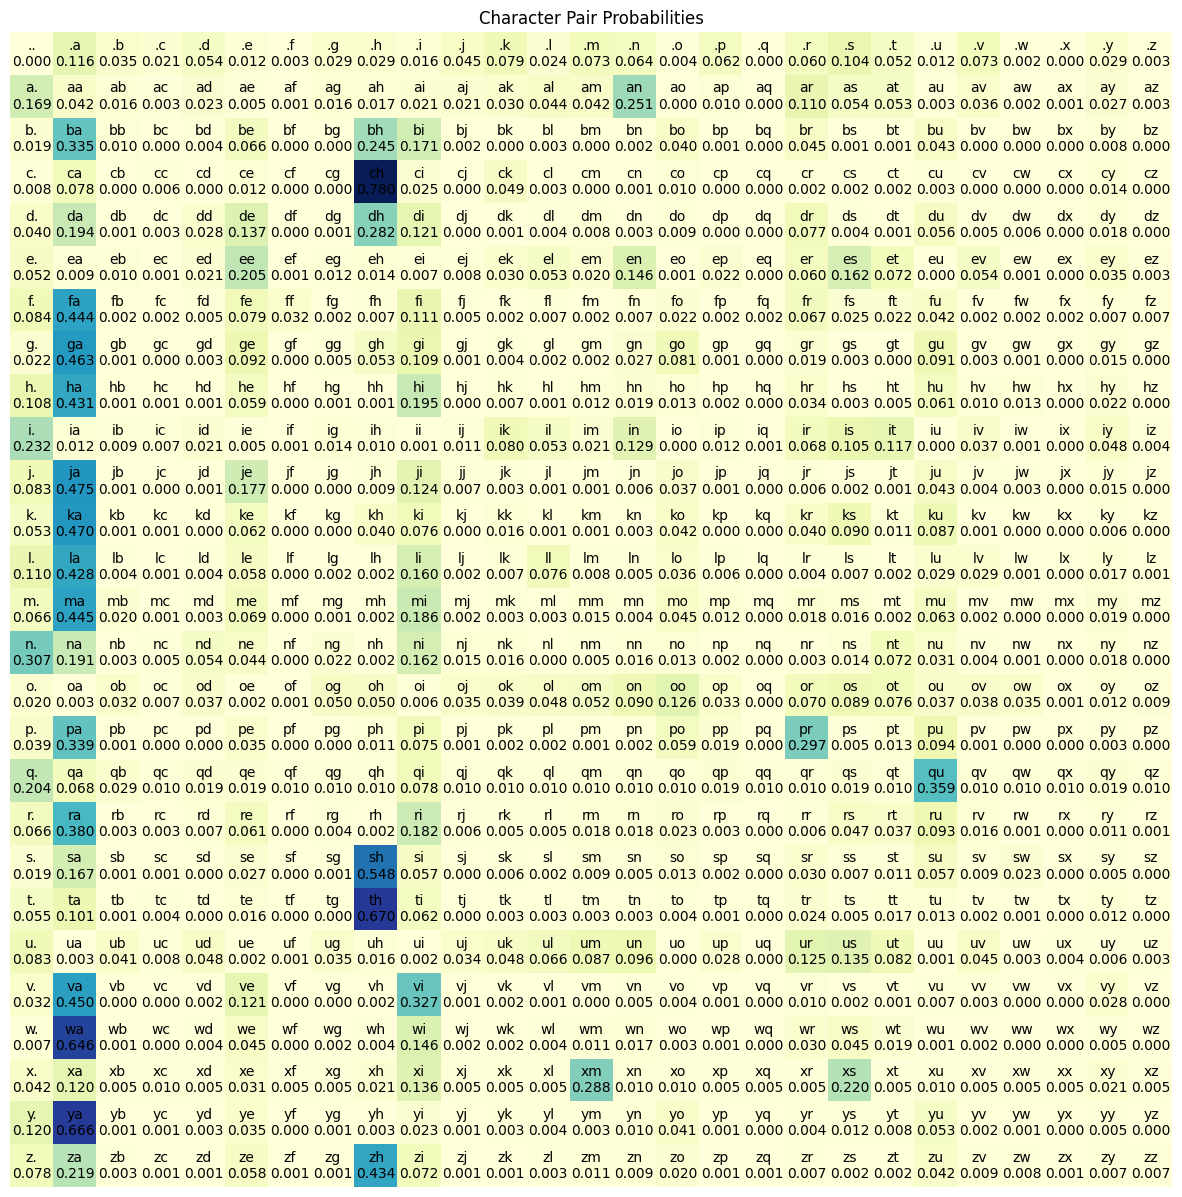

In [18]:
# Now, let's use these counts to calculate the probabilities of each character appearing after another character.
char_probs = char_counts / char_counts.sum(dim=1, keepdim=True)
# Let's visualize the probabilities using a heatmap.
plot_heatmap(char_probs, int_to_char, title="Character Pair Probabilities")

In [19]:
# Let's verify that the sum of probabilities for each character is 1 by summing the rows of the tensor
# for random characters.
print(char_probs[0].sum())
print(char_probs[5].sum())
print(char_probs[26].sum())

tensor(1.0000)
tensor(1.)
tensor(1.)


In [71]:
# As explained above, the rule based model essentially randomly samples the next character based on the probability 
# distribution of the current character. Let's implement this now. Since we are sampling from a probability distribution,
# the output might be different every time we run the code. However, it is easier to understand if we can reproduce the
# same output when the entire code is run again. It is important to place the code that sets the seed in the same cell
# as the code that uses the random functions. If not, the seed is set only once and eveytime the cell is run, it just
# takes values continuously from the random sequence and the output is not reproducible.
SEED = 1234

In [78]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

for _ in range(10):
    # Initially, the running name is empty.
    running_name = ""
    # We start with the bound_character (.) which is mapped to 0.
    predicted_char_idx = 0
    while True:    
        # Extract the probability distribution corresponding to the current character.
        current_char_probs = char_probs[predicted_char_idx]
        # Sample the next character based on the retrieved probability distribution in the previous step.
        predicted_char_idx = torch.multinomial(current_char_probs, num_samples=1).item()
        # If the predicted character is the bound_character, we break out of the loop.
        if predicted_char_idx == 0:
            break
        # Append the predicted character to the running name.
        running_name += int_to_char[predicted_char_idx]
    # Print the generated name.
    print(running_name)

k
velivadanilish
svarar
yaakumyin
thethi
kove
gasubhumath
thegarumady
inthinurath
arakujogohidumukokanusharina


In [79]:
# The above generated names might feel like gibberish -- Let's deal with this later.
# Let's take a step back and try to generate names completely randomly. This will help us understand the
# difference between the rule based model and the completely random model.
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
char_prob_random = torch.full(size=(27,), dtype=torch.float32, fill_value=1/27)

for _ in range(10):
    running_name = ""
    predicted_char_idx = 0
    while True:
        # Sample a random character from the character mapping.
        predicted_char_idx = torch.multinomial(char_prob_random, num_samples=1).item()
        # If the predicted character is the bound_character, we break out of the loop.
        if predicted_char_idx == 0:
            break
        # Append the predicted character to the running name.
        running_name += int_to_char[predicted_char_idx]
    # Print the generated name.
    print(running_name)

k
uxfpvvdczrlfiebivxdqgjypakzzyip
fututgmhovo
gcsqbzumttcstqewxryfvoyjidtliduxcpp
yrmknioxwhidxfukokxfxqkgbqzau
gnpl
wuktxjtlnzlewngds
tfacvsqlkyjkhdgelo
rjd
yssbtbrdowctiiuexewamjrwnfuazh


In [80]:
# If you compare the names generated by the rule based model and the completely random model, you will notice that the
# names generated by the rule based model are more realistic. This is because the rule based model has learned the
# patterns in the dataset and generates names based on those patterns. The completely random model, on the other hand,
# generates names completely randomly without any regard to the patterns in the dataset.
#
# However, the names generated by the rule based model still feel like gibberish. This is because the rule based model
# is very simple and is not a very good model for generating names itself. For example, the rule based modle predicts
# the next character based only on the current character and does not take into account the context of the entire name.